In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

# Linear transformation

In [2]:
n = 500
z0 = np.random.rand(n, 2)*4 - 2
def q0(z0):
    return np.apply_along_axis(lambda x: 1./16 if -2<=x[0]<=2 and -2<=x[0]<=2 else 0, 1, z0)

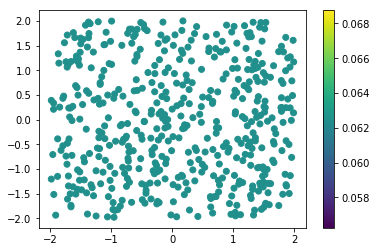

In [3]:
sc = plt.scatter(z0[:, 0], z0[:, 1], c=q0(z0));
plt.colorbar(sc)
plt.show()

In [4]:
def linear_flow(z, w, u, b):
    logit = np.dot(z, w) + b
    s = 1./(1. + np.exp(-logit))
    fz = z + np.dot(s.reshape([-1, 1]), u.reshape([1, -1]))
    
    psi = (s*(1-s)).reshape([-1, 1]) * w
    det = np.abs(1 + np.dot(psi, u.reshape([-1, 1])))
    
    return fz, det

In [5]:
fz, det = linear_flow(z0, w=np.array([10, 7]), u=np.array([-0.2, 0.2]), b=0.2)

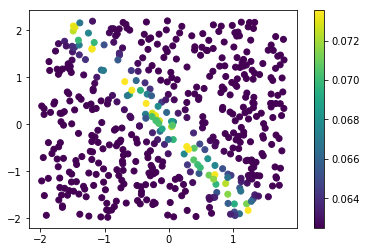

In [6]:
sc = plt.scatter(fz[:, 0], fz[:, 1], c=np.divide(q0(z0).reshape([-1, 1]), det).ravel());
plt.colorbar(sc)
plt.show()

## Training a flow

In [7]:
K = 32
tf.reset_default_graph()

In [8]:
base_dist = tf.distributions.Uniform(low=[-4.0, -4.0], high=[4.0, 4.0])
target_dist = tf.distributions.Normal(loc=[0., 0.], scale=[1., 1.])
def target_dist(z):
    norm = tf.sqrt(tf.reduce_sum(tf.square(z), axis=1))
    exp1 = tf.exp(-0.5 * ((z[:, 0] - 2) / 0.8) ** 2)
    exp2 = tf.exp(-0.5 * ((z[:, 0] + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - tf.log(exp1 + exp2)
    return tf.exp(-u)

z0 = base_dist.sample(n)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [9]:
def h(z):
    return 1./(1+tf.exp(-z))

In [10]:
def tf_linear_flow(z, w, u, b):
    s = h(tf.matmul(z, tf.transpose(w)) + b)
    fz = z + tf.matmul(s, u)
    
    psi = (s*(1-s)) * w
    det = tf.abs(1 + tf.matmul(psi, tf.transpose(u)))
    
    return fz, det

In [11]:
z = z0
cum_log_det = 0

for i in range(K):
    with tf.variable_scope("layer_{}".format(i)):
        u = tf.get_variable('u', shape=(1, 2))
        w = tf.get_variable('w', shape=(1, 2))
        b = tf.get_variable('b', shape=())
        
        fz, det = tf_linear_flow(z, w, u, b)
        z = fz
        cum_log_det += tf.log(det)
        
log_q0 = tf.reduce_sum(base_dist.log_prob(z0)) - cum_log_det
log_qz = tf.log(1e-7 + target_dist(z))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
kl = tf.reduce_mean(log_q0 - log_qz)

In [13]:
train_op = tf.train.AdamOptimizer(1e-4).minimize(kl)
init_op = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


i: 0 KL: -2067.9653


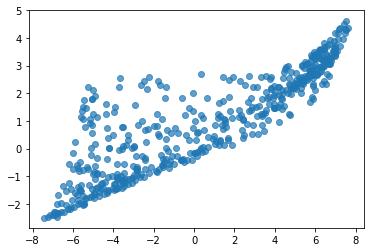

i: 1000 KL: -2071.6462
i: 2000 KL: -2073.237
i: 3000 KL: -2074.1848
i: 4000 KL: -2075.3542
i: 5000 KL: -2075.656


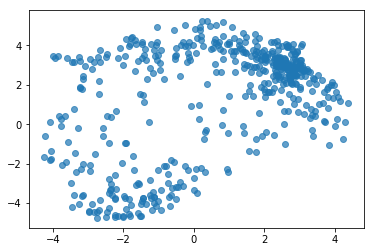

i: 6000 KL: -2076.2268
i: 7000 KL: -2076.4214
i: 8000 KL: -2076.549
i: 9000 KL: -2076.8113
i: 10000 KL: -2076.8293


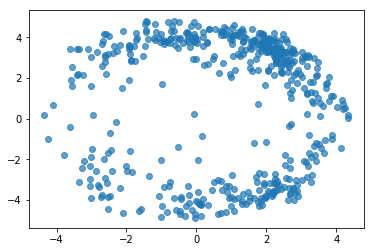

i: 11000 KL: -2076.9812
i: 12000 KL: -2076.9346
i: 13000 KL: -2077.1035
i: 14000 KL: -2077.026
i: 15000 KL: -2077.1814


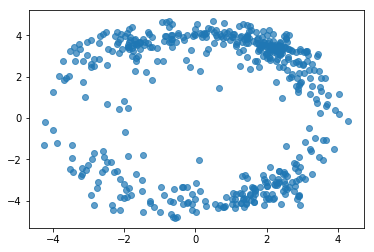

i: 16000 KL: -2077.1313
i: 17000 KL: -2077.1555
i: 18000 KL: -2077.1365
i: 19000 KL: -2077.2236
i: 20000 KL: -2077.212


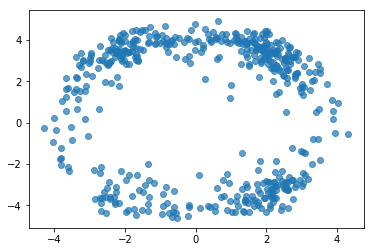

i: 21000 KL: -2077.3306
i: 22000 KL: -2077.2795
i: 23000 KL: -2077.38
i: 24000 KL: -2077.3127
i: 25000 KL: -2077.3276


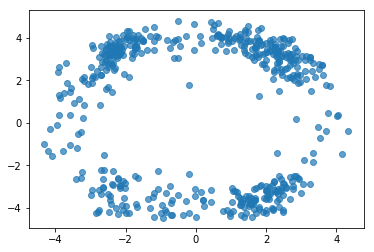

i: 26000 KL: -2077.373
i: 27000 KL: -2077.3235
i: 28000 KL: -2077.3984
i: 29000 KL: -2077.34
i: 30000 KL: -2077.4011


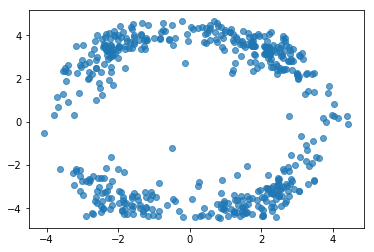

i: 31000 KL: -2077.3286
i: 32000 KL: -2077.4583
i: 33000 KL: -2077.375
i: 34000 KL: -2077.4207
i: 35000 KL: -2077.3572


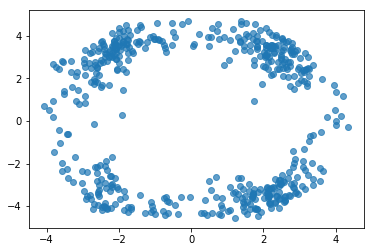

i: 36000 KL: -2077.4058
i: 37000 KL: -2077.382
i: 38000 KL: -2077.4075
i: 39000 KL: -2077.4246
i: 40000 KL: -2077.4512


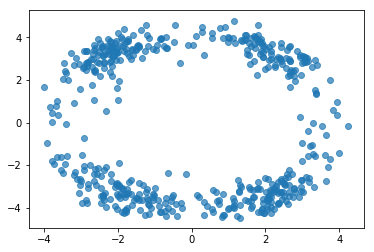

In [14]:
with tf.Session() as sess:
    sess.run(init_op)

    for i in range(40000 + 1):
        _, kl_np = sess.run([train_op, kl])
        if i % 1000 == 0:
            print('i:', i, 'KL:', kl_np)
        if i % 5000 == 0:
            z_k_np = sess.run(z)
            plt.scatter(z_k_np[:, 0], z_k_np[:, 1], alpha=0.7)
            plt.show()